In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
from playlist_recommender.modelling import model_pipeline, utils
import joblib
import json
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from pathlib import Path

In [2]:
X, y = utils.prep_playlist_df()
X_train, X_test, y_train, y_test = model_pipeline.make_best_transformation_pipeline(
    X, y
)

pipeline dumped


In [3]:
def get_top_n_prediction_indices(prediction_array: np.array, n: int):
    return np.flip(np.argsort(prediction_array)[-n:])

In [4]:
def get_top_n_prediction_probas(prediction_array: np.array, n: int):
    return sorted(prediction_array, reverse=True)[:n]

In [5]:
def make_prediction(model, row, le_dict: dict):
    return le_dict[str(np.argmax(model.predict(row)))]

In [6]:
def get_top_n_predictions(prediction_array: np.array, n: int, encoder_dict: dict):
    top_indices = get_top_n_prediction_indices(prediction_array, n)
    predictions_list = []
    for idx in top_indices:
        predictions_list.append(encoder_dict[str(idx)])
    return predictions_list

In [11]:
trained_model_dir = Path(Path.cwd(), "trained_nn_model")

In [12]:
model = tf.keras.models.load_model(trained_model_dir)

2022-10-13 17:28:53.285700: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
liked_songs_dir = Path(Path.cwd().parent, "data", "liked_songs_df.pkl")
liked_songs = pd.read_pickle(liked_songs_dir)

In [17]:
liked_artists = liked_songs["artist_names"].to_list()
liked_tracks = liked_songs["track_names"].to_list()
zipped_artists_tracks = tuple(zip(liked_artists, liked_tracks))

In [18]:
pipeline = joblib.load("pipeline.pkl")

In [20]:
json_dir = Path(Path.cwd(), "label_encoding.json")
with open(json_dir, "r") as f:
    le_dict = json.load(f)

In [21]:
transformed = pipeline.transform(liked_songs)

In [22]:
predictions = model.predict(transformed)

21/21 [==============================] - 1s 8ms/step


In [23]:
top_1_predicted_labels = []
for array in predictions:
    _predictions_labels = get_top_n_predictions(array, 1, le_dict)
    top_1_predicted_labels.append(_predictions_labels)
top_1_predictions_dict = dict(zip(zipped_artists_tracks, top_1_predicted_labels))

In [24]:
top_1_predictions_values = list(
    itertools.chain.from_iterable(list(top_1_predictions_dict.values()))
)

In [39]:
predictions_dict = {"first":[], 
                    "first_proba":[], 
                    "second":[], 
                    "second_proba":[], 
                    "third":[], 
                    "third_proba":[]}

for i, array in enumerate(predictions):
    predictions_dict["first"].append(le_dict[str(get_top_n_prediction_indices(array, 1)[0])])
    predictions_dict["first_proba"].append(get_top_n_prediction_probas(array, n=1)[0])
    predictions_dict["second"].append(le_dict[str(get_top_n_prediction_indices(array, 2)[1])])
    predictions_dict["second_proba"].append(get_top_n_prediction_probas(array, n=2)[1])
    predictions_dict["third"].append(le_dict[str(get_top_n_prediction_indices(array, 3)[2])])
    predictions_dict["third_proba"].append(get_top_n_prediction_probas(array, n=3)[2])

In [42]:
df = pd.DataFrame.from_dict(predictions_dict)
df["artist name"] = liked_artists
df["track name"] = liked_tracks

In [43]:
df.head()

,first,first_proba,second,second_proba,third,third_proba,artist name,track name
0,80's Hits,0.490375,Guilty Pleasures,0.110621,Summer Songs,0.110617,Elton John,All The Girls Love Alice - Remastered 2014
1,Discovered Weekly,0.336936,Your Top Songs 2019,0.252830,Easy Sunday,0.168270,Brian Protheroe,Pinball
2,Austin 2.0,0.286915,Summer Tunes,0.132632,Discovered Weekly,0.129641,Lo Moon,Dream Never Dies
3,Summer Songs,0.702904,80's Hits,0.135461,Chill,0.045541,Nation of Language,Across That Fine Line
4,Summer Songs,0.123992,Old Summer Stuff,0.121701,Discovered Weekly,0.088711,Harvey Danger,Flagpole Sitta


In [21]:
df.sort_values("first prediction proba", ascending=False).head()

,artist name,track name,first prediction,first prediction proba,second prediction,second prediction proba,third prediction,third prediction proba
471,Shinedown,Cut the Cord,Gym,0.998811,Guilty Pleasures,0.000878,00s house party,0.000157
454,Kanye West,All Falls Down,Gym,0.995760,Guilty Pleasures,0.001778,Trance,0.001618
442,The White Stripes,Little Cream Soda,Gym,0.995546,Guilty Pleasures,0.001953,Trance,0.001307
658,The Magician,Sunlight (feat. Years and Years) - Radio Edit,briz party songz,0.989554,Summer Tunes,0.004005,Trance,0.003944
494,Kanye West,Famous,Gym,0.989508,Guilty Pleasures,0.006791,Trance,0.002734


# Filtering

If a song already exists in a playlist, it shouldn't be included.

In [46]:
playlist_df_dir = Path(Path.cwd().parent, "data", "playlist_df.pkl")
playlist_df = pd.read_pickle(playlist_df_dir)

In [73]:
# Have to rename the playlist_df columns to match the predictions df for merging
playlist_df_filtered = playlist_df[["track_names", "artist_names", "playlist_name"]]
playlist_df_filtered = playlist_df_filtered.rename(
    columns={
        "track_names": "track name",
        "artist_names": "artist name",
        "playlist_name": "first prediction",
    }
)

In [75]:
""" merge the playlist_df with the predictions_df
extract tracks that exist in both liked songs and predictions
combine the predictions_df with the tracks that exist in both
then drop duplicates, leaving only the prediction tracks that dont 
exist in the liked song df
"""

playlist_df_merged = playlist_df_filtered.merge(df, how="left", indicator=True)
exist_in_both = playlist_df_merged[playlist_df_merged["_merge"] == "both"]
final_prediction_df = (
    pd.concat([df, exist_in_both])
    .drop_duplicates(keep=False, subset=["artist name", "track name"])
    .drop(["_merge","first prediction"], axis=1)
    .reset_index(drop=True)
)

In [65]:
final_prediction_df.sort_values(by="first_proba", ascending=False).head()

,first,first_proba,second,second_proba,third,third_proba,artist name,track name
328,Gym,0.996333,Guilty Pleasures,0.001442,00s house party,0.000816,Kanye West,Famous
156,Summer Tunes,0.992955,Austin,0.002048,Chill,0.001384,Sam Feldt,Start Again
300,Gym,0.992930,Summer Tunes,0.002107,Guilty Pleasures,0.001538,Jax Jones,You Don't Know Me
298,Gym,0.992784,briz party songz,0.002090,00s house party,0.001624,Kanye West,Waves
34,Floyd,0.992685,60s/70s,0.003045,Classic Rock,0.002366,Pink Floyd,Lost for Words


In [31]:
final_prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   artist name              506 non-null    object 
 1   track name               506 non-null    object 
 2   first prediction         506 non-null    object 
 3   first prediction proba   506 non-null    float32
 4   second prediction        506 non-null    object 
 5   second prediction proba  506 non-null    float32
 6   third prediction         506 non-null    object 
 7   third prediction proba   506 non-null    float32
dtypes: float32(3), object(5)
memory usage: 25.8+ KB


# Prediction Visualization

In [76]:
filtered_counts = Counter(final_prediction_df["first"])
filtered_plot_data = sorted(
    final_prediction_df["first"], key=filtered_counts.get, reverse=True
)

In [77]:
counts_df = pd.DataFrame.from_dict(filtered_counts, orient="index").reset_index()

In [78]:
counts_df.columns = ["playlist name", "count"]

Text(0.5, 0, 'Count')

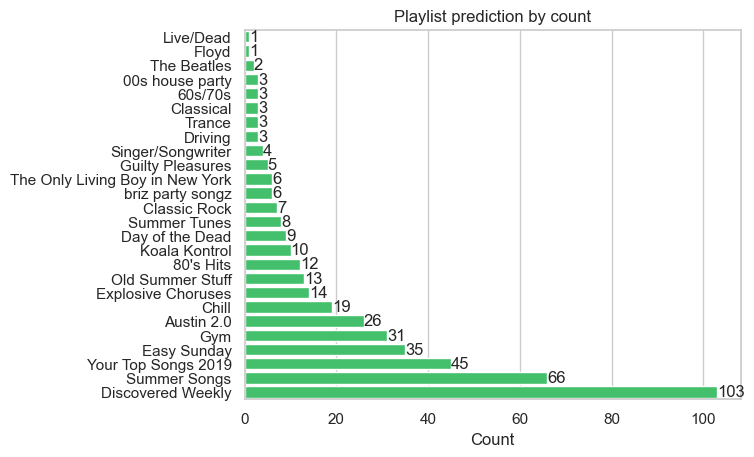

In [139]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='count', 
                 y='playlist name', 
                 data=counts_df.sort_values(by='count'), 
                 color = '#2FD566')
ax.bar_label(ax.containers[0]);
ax.set_title("Playlist prediction by count")
ax.set_ylabel("")
ax.set_xlabel("Count")

Text(0.5, 1.0, 'Count of predictions by prediction confidence')

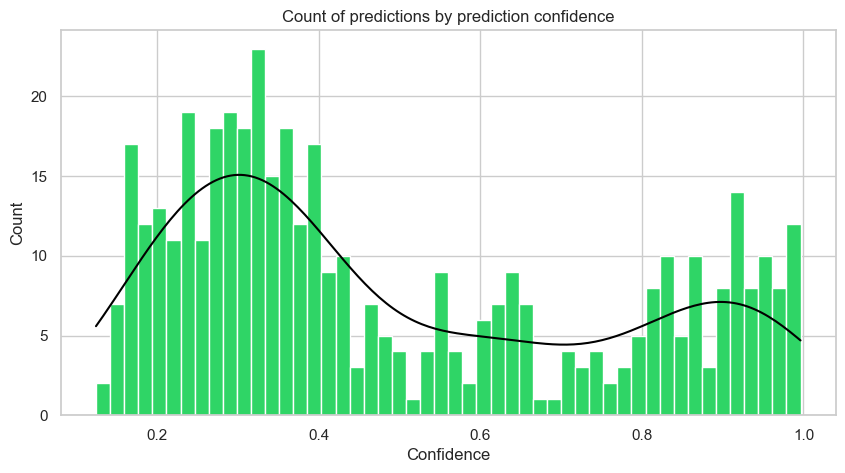

In [136]:
fig, ax = plt.subplots(figsize = (10,5))
ax = sns.histplot(data = final_prediction_df, 
             x = 'first_proba', 
             kde = True, 
             bins = 50, 
             color = '#2FD566', 
             alpha = 1, )
ax.lines[0].set_color('black') #passing kde color to kdekwargs doesnt seem to work
ax.set_xlabel('Confidence')
ax.set_title("Count of predictions by prediction confidence")